In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Introduction

In this project I will be analyzing a bank loan marketing conversion dataset obtained from Kaggle (https://www.kaggle.com/datasets/arashnic/banking-loan-prediction/data). The dataset features attributes that pertain to a bank loan application. The dataset includes several columns regarding the applicants background, the source of the application, terms of the bank loan, and whether or not the loan was approved.

This project aims to analyze lead approval rates across source categories using A/B testing and predictive modeling. By examining patterns and relationships within the data, we seek to uncover insights that can inform business strategies.

### Exploratory Data Analysis

##### Dataset Overview:

In [2]:
df = pd.read_csv("../data/train_loan/train.csv")

print(f"This dataset has {df.shape[0]} rows and {df.shape[1]} attributes. ")

print(df.describe())

df.head()

This dataset has 69713 rows and 22 attributes. 
       Employer_Category2  Monthly_Income   Existing_EMI    Loan_Amount  \
count        65415.000000    6.971300e+04   69662.000000   42004.000000   
mean             3.720187    5.622283e+03     360.928751   39429.982859   
std              0.807374    1.747671e+05    2288.517927   30727.595990   
min              1.000000    0.000000e+00       0.000000    5000.000000   
25%              4.000000    1.650000e+03       0.000000   20000.000000   
50%              4.000000    2.500000e+03       0.000000   30000.000000   
75%              4.000000    4.000000e+03     350.000000   50000.000000   
max              4.000000    3.838384e+07  545436.500000  300000.000000   

        Loan_Period  Interest_Rate           EMI          Var1      Approved  
count  42004.000000   22276.000000  22276.000000  69713.000000  69713.000000  
mean       3.890629      19.213570   1101.466242      3.948446      0.014631  
std        1.167491       5.847136    7

,ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,...,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
0,APPC90493171225,Female,23/07/79,15/07/16,C10001,A,COM0044082,A,4.0,2000.0,...,N,S122,G,0.0,NaN,NaN,NaN,NaN,0,0
1,APPD40611263344,Male,07/12/86,04/07/16,C10003,A,COM0000002,C,1.0,3500.0,...,Y,S122,G,0.0,20000.0,2.0,13.25,953.0,10,0
2,APPE70289249423,Male,10/12/82,19/07/16,C10125,C,COM0005267,C,4.0,2250.0,...,Y,S143,B,0.0,45000.0,4.0,NaN,NaN,0,0
3,APPF80273865537,Male,30/01/89,09/07/16,C10477,C,COM0004143,A,4.0,3500.0,...,Y,S143,B,0.0,92000.0,5.0,NaN,NaN,7,0
4,APPG60994436641,Male,19/04/85,20/07/16,C10002,A,COM0001781,A,4.0,10000.0,...,Y,S134,B,2500.0,50000.0,2.0,NaN,NaN,10,0


##### Data Cleaning:

In [3]:
#Removing any duplicate rows
df.drop_duplicates(inplace=True)

print(df.info())

null_rows_sum = df.isnull().any(axis=1).sum()
print(f"There are {null_rows_sum} rows with atleast one null value in a column.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69713 entries, 0 to 69712
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ID                                   69713 non-null  object 
 1   Gender                               69713 non-null  object 
 2   DOB                                  69698 non-null  object 
 3   Lead_Creation_Date                   69713 non-null  object 
 4   City_Code                            68899 non-null  object 
 5   City_Category                        68899 non-null  object 
 6   Employer_Code                        65695 non-null  object 
 7   Employer_Category1                   65695 non-null  object 
 8   Employer_Category2                   65415 non-null  float64
 9   Monthly_Income                       69713 non-null  float64
 10  Customer_Existing_Primary_Bank_Code  60322 non-null  object 
 11  Primary_Bank_Type           

Many of the attributes have null values in 1 or more rows, however since the initial A/B tests will only make use of the Approved and Source_Category columns, which don't have any null values, we do not need to discard or impute any rows for now.

Next I will check for outliers, before doing so I must convert the DOB and Lead_Creation_Date columns to Age, and Lead_Age.

In [4]:
#Converting lead creation date and DOB to datetime
df["Lead_Creation_Date"] = pd.to_datetime(df["Lead_Creation_Date"])
df["DOB"] = pd.to_datetime(df["DOB"])

#Finding most recent loan creation date
most_recent_date = df["Lead_Creation_Date"].max()

#Calculating loan application age in years
df["Lead_Age"] = (most_recent_date - df["Lead_Creation_Date"]).dt.days / 365

#Calculating age of applicants in years
df["Age"] = (most_recent_date - df["DOB"]).dt.days / 365

print(df["Age"].describe())
print(df["Lead_Age"].describe())

max_dob = df["DOB"].max()
print(max_dob)

C:\Users\dimdi\AppData\Local\Temp\ipykernel_8344\1392067781.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Lead_Creation_Date"] = pd.to_datetime(df["Lead_Creation_Date"])
C:\Users\dimdi\AppData\Local\Temp\ipykernel_8344\1392067781.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DOB"] = pd.to_datetime(df["DOB"])


count    69698.000000
mean        22.841209
std         22.893110
min        -58.093151
25%         25.284932
50%         28.465753
75%         32.254795
max         41.967123
Name: Age, dtype: float64
count    69713.000000
mean         0.365079
std          0.207192
min          0.000000
25%          0.224658
50%          0.312329
75%          0.405479
max          0.923288
Name: Lead_Age, dtype: float64
2074-12-29 00:00:00


We can see that the new Age column has a minimum value of -58, after checking the maximum date of birth, we can see that one of the applicants has their birth year set to 2074, which is clearly an error.

I will now replace the outliers using the interquartile range method. To better preserve the scope of the data, I will raise the threshold value for the IQR range from a standard 1.5 to 4.5. This way only the most extreme outliers will be set to null and later imputed.

I will take a different approach with the age column however, instead of using the IQR range I will simply set values under 18 years to null, since the current maximum age of 42 years is acceptable.

In [5]:
numerical_columns = ["Monthly_Income", "Existing_EMI", "Loan_Amount", "Loan_Period", "Interest_Rate", "EMI", "Age", "Lead_Age"]

for col in df[numerical_columns]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - (4.5 * IQR)
    upper_bound = Q3 + (4.5 * IQR)

    if col == "Age":
        num_outliers = ((df[col] < 18)).sum()
        print(f"Column {col}: {num_outliers} outliers replaced with NaN.")
        df[col] = df[col].mask((df[col] < 18))
    else:
        num_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        print(f"Column {col}: {num_outliers} outliers replaced with NaN.")
        df[col] = df[col].mask((df[col] < lower_bound) | (df[col] > upper_bound))

df[numerical_columns].describe()

Column Monthly_Income: 1729 outliers replaced with NaN.
Column Existing_EMI: 3211 outliers replaced with NaN.
Column Loan_Amount: 124 outliers replaced with NaN.
Column Loan_Period: 0 outliers replaced with NaN.
Column Interest_Rate: 0 outliers replaced with NaN.
Column EMI: 154 outliers replaced with NaN.
Column Age: 5833 outliers replaced with NaN.
Column Lead_Age: 0 outliers replaced with NaN.


,Monthly_Income,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Age,Lead_Age
count,67984.000000,66451.000000,41880.000000,42004.000000,22276.000000,22122.000000,63865.000000,69713.000000
mean,3035.341438,196.711859,38884.765998,3.890629,19.213570,1073.257752,29.607387,0.365079
std,2122.256046,383.288838,29051.539138,1.167491,5.847136,666.681053,4.672571,0.207192
min,0.000000,0.000000,5000.000000,1.000000,11.990000,118.000000,18.013699,0.000000
25%,1600.000000,0.000000,20000.000000,3.000000,15.250000,639.000000,26.131507,0.224658
50%,2500.000000,0.000000,30000.000000,4.000000,18.000000,934.000000,29.041096,0.312329
75%,3800.000000,250.000000,50000.000000,5.000000,20.000000,1276.000000,32.668493,0.405479
max,14550.000000,1923.000000,185000.000000,6.000000,37.000000,4194.000000,41.967123,0.923288


Outliers have been removed, upon looking at the description of the data we can see that all min, max and mean values are acceptable.

Before proceeding to feature engineering and visualization, I will drop unneeded and inapplicable columns as they will slow down computation time and interfere with the predictive modeling. To build the predictive model using logistic regression, I will have to factor all categorical columns to into binary columns using One Hot Encoding. This algorithm will encode the categorical variables by creating a new binary column for each unique value for each categorical variable. Depending on the amount of unique values (cardinality) in the categorical variables, this method may massively overfit the logistic regression model. Therefore it would wise to drop categorical columns that have high cardinality. This will also assist in making the visualization of the categorical variables easier to interpret.

In [6]:
categorical_columns = ["Gender", "City_Code", "City_Category", "Employer_Code", "Employer_Category1", "Employer_Category2", "Customer_Existing_Primary_Bank_Code", "Primary_Bank_Type", "Contacted", "Source", "Source_Category"]

for col in categorical_columns:
    unique_count = df[col].nunique()
    print(f" Unique Values in column {col} = {unique_count}")

 Unique Values in column Gender = 2
 Unique Values in column City_Code = 678
 Unique Values in column City_Category = 3
 Unique Values in column Employer_Code = 36617
 Unique Values in column Employer_Category1 = 3
 Unique Values in column Employer_Category2 = 4
 Unique Values in column Customer_Existing_Primary_Bank_Code = 57
 Unique Values in column Primary_Bank_Type = 2
 Unique Values in column Contacted = 2
 Unique Values in column Source = 29
 Unique Values in column Source_Category = 7


We can see that City_Code, Employer_Code, Customer_Existing_Primary_Bank_Code and Source have the highest cardinalities. These columns will be removed, as introducing that many individual binary columns into the logistic regression will overfit the model. The columns to be removed also each have their own respective category columns ("City_Category", "Employer_Category1", "Employer_Category2", "Primary_Bank_Type" and "Source_Category") which will do a good job of representing the removed columns in the model. 

I will also drop the ID column since it is simply the customers ID and does not help in determining approval. The "Var1" column will also be dropped, as it is not clear what it represents due to it's ambiguous title and Kaggle description: "Anonymized Categorical variable with multiple levels".

In [7]:
df = df.drop(columns=["ID", "Var1", "DOB", "Lead_Creation_Date", "City_Code", "Employer_Code", "Customer_Existing_Primary_Bank_Code", "Source"])

#Updating categorical columns:
categorical_columns = ["Gender", "City_Category", "Employer_Category1", "Employer_Category2", "Primary_Bank_Type", "Contacted", "Source_Category"]

##### Feauture Engineering:

I will now create the Total_Loan_Amount column which is the loan amount for the entire loan period including interest rate. This column will be used in A/B testing.

In [8]:
df["Total_Loan_Amount"] = df["Loan_Amount"] * (1 + (df["Interest_Rate"]/100) * df["Loan_Period"])
df["Total_Loan_Amount"].describe()

#Updating the numerical columns
numerical_columns = ["Monthly_Income", "Existing_EMI", "Loan_Amount", "Loan_Period", "Interest_Rate", "EMI", "Age", "Lead_Age", "Total_Loan_Amount"]

##### Visualizations:

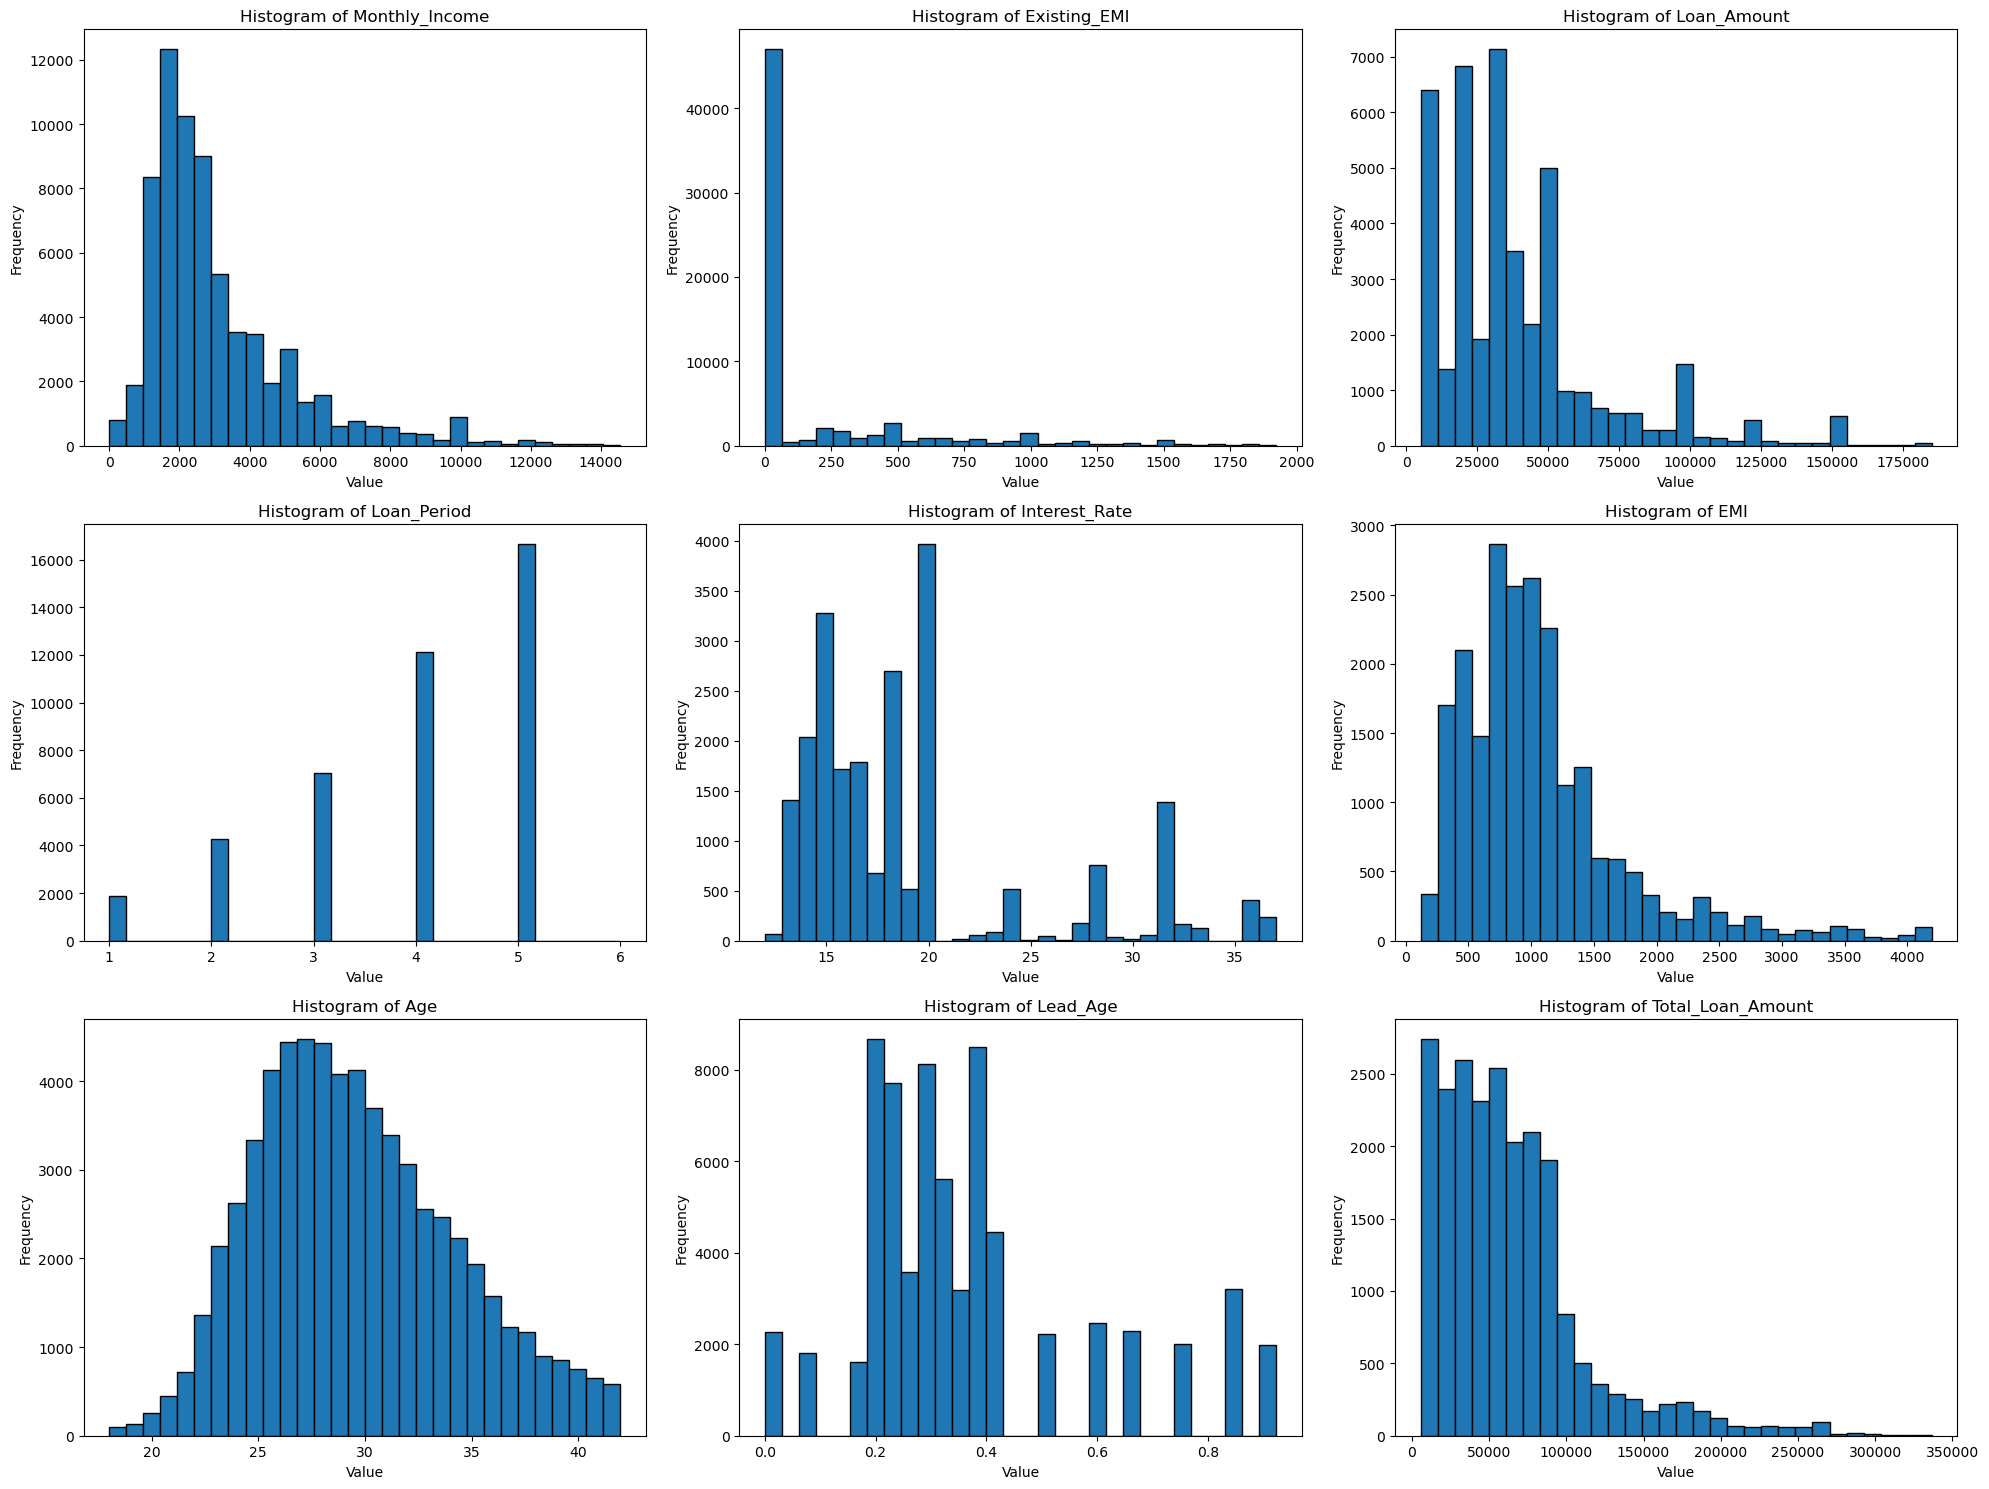

In [9]:
#Grid layout:
n_cols = 3
n_rows = 3

plt.figure(figsize=(20, 15))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(df[col], bins=30, edgecolor="black")
    plt.title(f"Histogram of {col}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

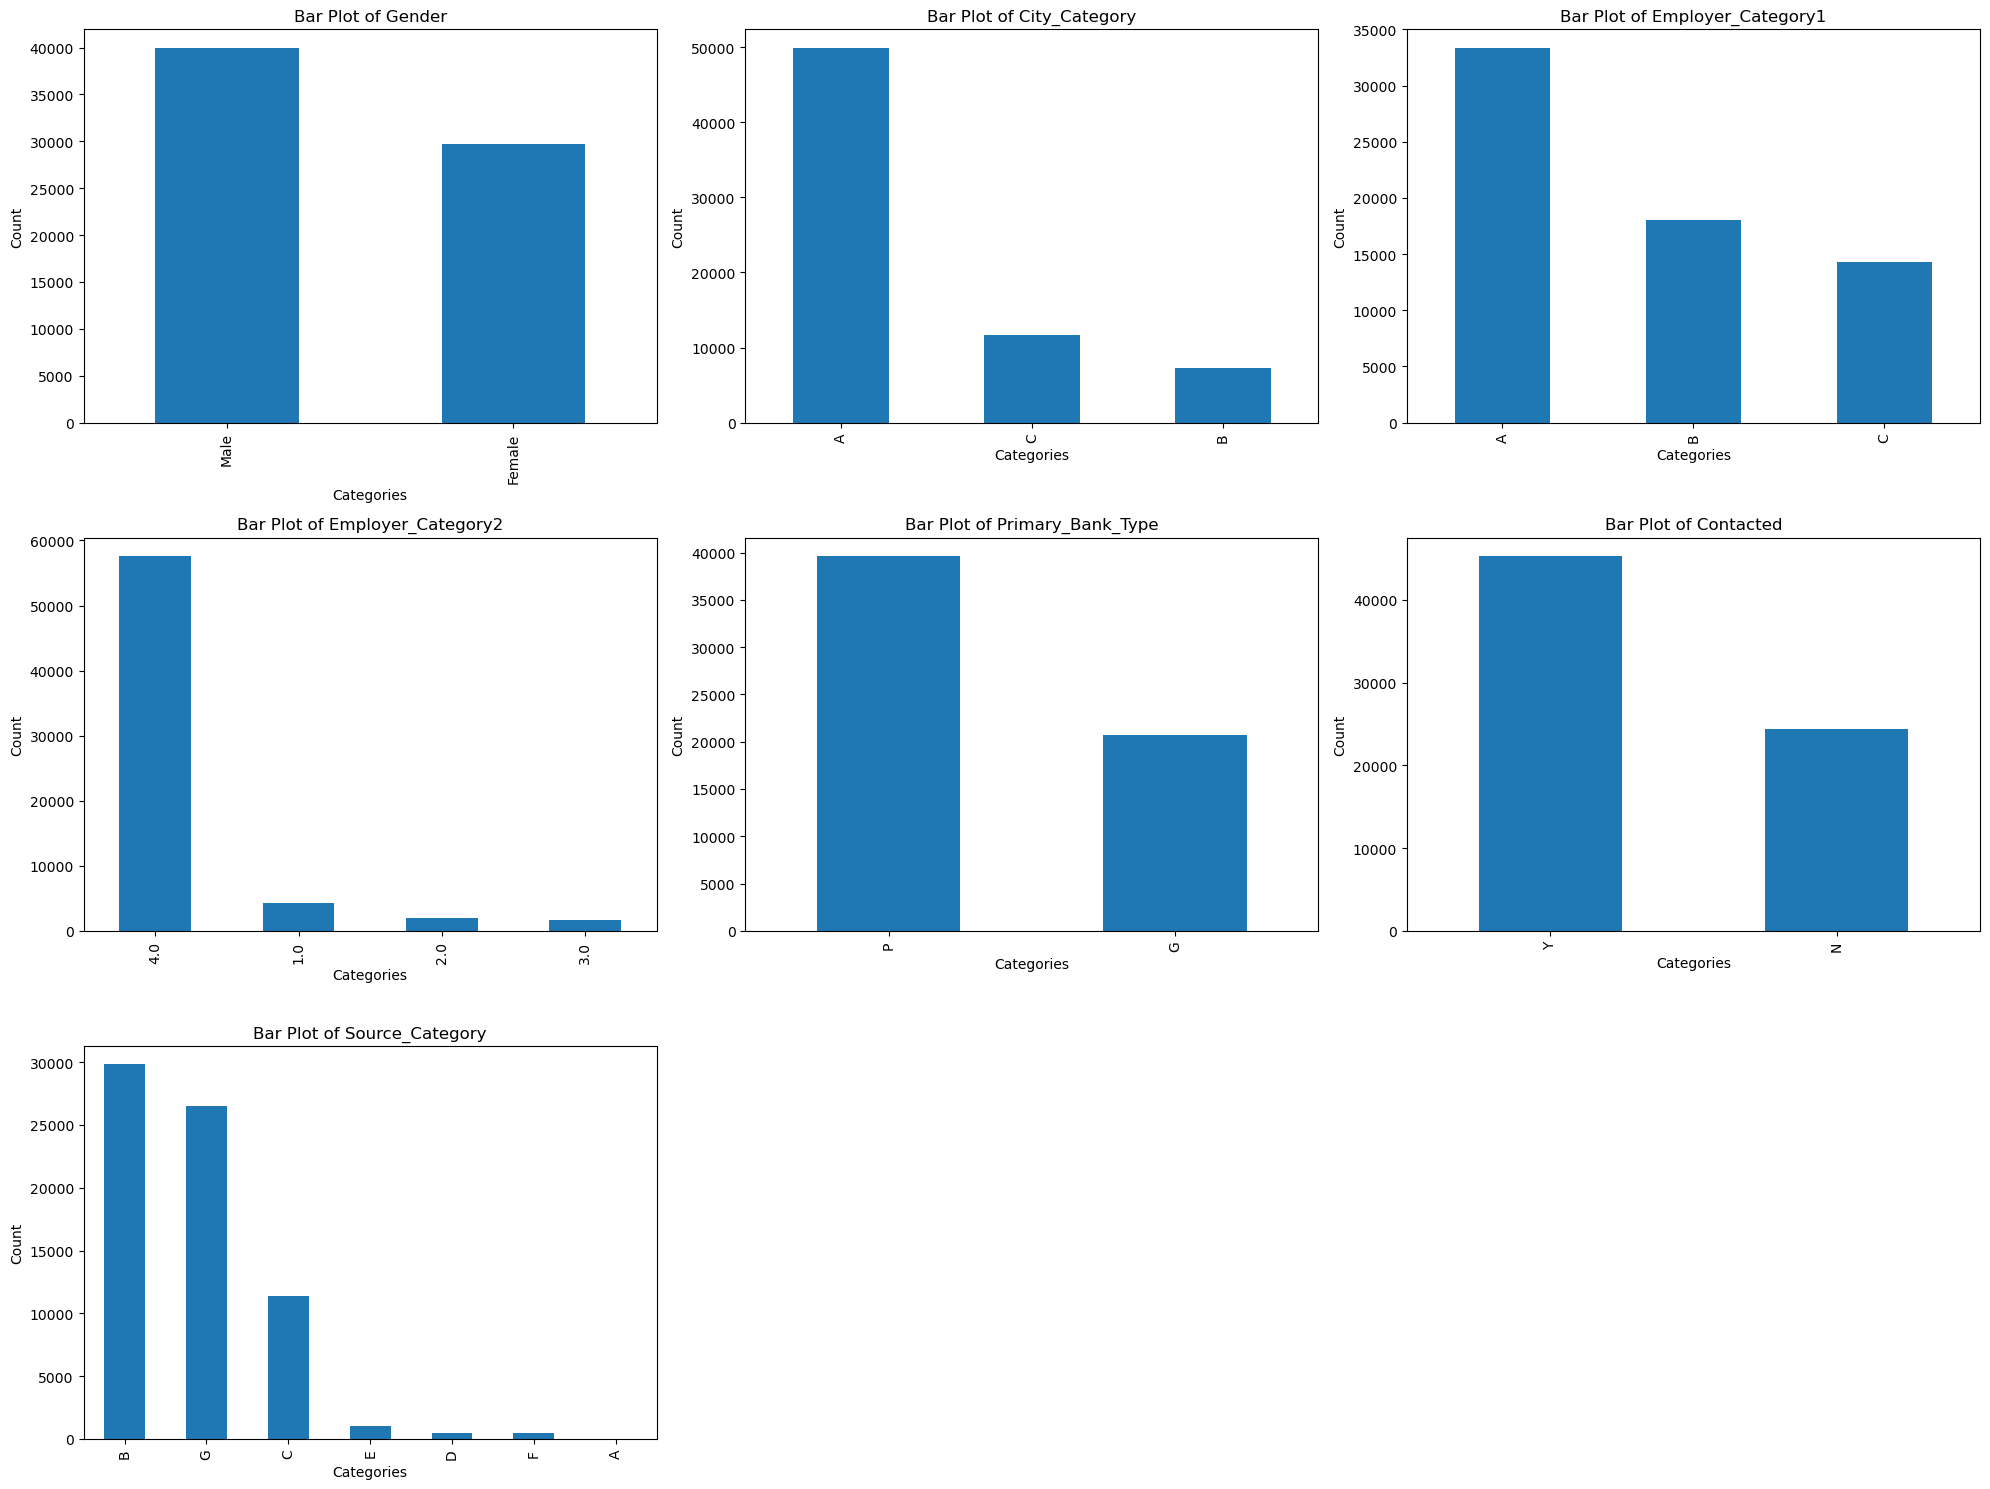

In [10]:
n_cols = 3
n_rows = 3

plt.figure(figsize=(20, 15))

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    
    value_counts = df[col].value_counts()

    value_counts.plot(kind="bar")
    plt.title(f"Bar Plot of {col}")
    plt.xlabel("Categories")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Statistical Tests:

For the initial A/B tests I will explore the approval rate amongst the lead source categories, to determine which categories are the most effective.

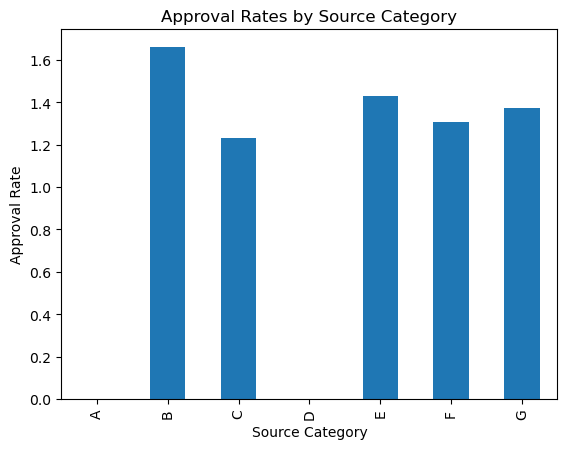

In [11]:
approval_rates = df.groupby("Source_Category")["Approved"].mean() * 100
approval_rates.plot(kind="bar")
plt.title("Approval Rates by Source Category")
plt.ylabel("Approval Rate")
plt.xlabel("Source Category")
plt.show()


We can see from the above barplot that there are 7 distinct source categories. B and G are the most commonly occuring categories by a substantial amount. However, category E which is the fourth most common source category has the second highest approval rating. Therefore it is worthwile to explore whether the approval rating of category E is significantly greater than that of cateogry G.

First however, I will test the significance of the difference between the approval ratings of categories B and G, the two most commonly occuring categories.

### Research Hypothesis:

Null Hypothesis (H<sub>0</sub>): There <strong>is no</strong> statistically significant difference in the loan approval rate between the "G" and "B" lead source categories.

Alternative Hypothesis (H<sub>1</sub>): There <strong>is</strong> a statistically significant difference in the loan approval rate between the "G" and "B" lead source categories.


### A/B Testing Using the Chi-Square Test

For this series of A/B tests I will use the Chi-Square test. Since we are dealing with categorical data and there are many data points, the Chi-Square test is the most appropriate.

In [12]:
#Setting the significance level at a standard value of 0.05
alpha = 0.05

#Filtering dataset
df_filtered = df[df["Source_Category"].isin(["G", "B"])]

#Calculating approval rates
approval_rates = df_filtered.groupby("Source_Category")["Approved"].mean() * 100
print(approval_rates)

#Creating contingency table needed for the Chi-Square test
contingency_table = pd.crosstab(df_filtered["Source_Category"], df_filtered["Approved"])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-Square Statistic: {chi2}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("\nReject the null hypothesis: There is a significant difference in approval rates between the B and G source categories.")
else:
    print("\nFail to reject the null hypothesis: There is no significant difference in approval between the B and G source categories.")
     

Source_Category
B    1.660405
G    1.372653
Name: Approved, dtype: float64

Chi-Square Statistic: 7.547966987422923
P-value: 0.006007781759069996

Reject the null hypothesis: There is a significant difference in approval rates between the B and G source categories.


The Chi-Square test yielded a p-value of approximately 0.006. This is less than the set significance level of 0.05, which means we reject the null hypothesis and conclude that there is indeed a significant difference in approval rates in leads between the B and G source categories.

Now let's see if source category E is also significantly greater than G. 

Null Hypothesis (H<sub>0</sub>): There <strong>is no</strong> statistically significant difference in the loan approval rate between the "G" and "E" lead source categories.

Alternative Hypothesis (H<sub>1</sub>): There <strong>is</strong> a statistically significant difference in the loan approval rate between the "G" and "E" lead source categories.

In [13]:
df_filtered = df[df["Source_Category"].isin(["G", "E"])]

approval_rates = df_filtered.groupby("Source_Category")["Approved"].mean() * 100
print(approval_rates)

contingency_table = pd.crosstab(df_filtered["Source_Category"], df_filtered["Approved"])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-Square Statistic: {chi2}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("\nReject the null hypothesis: There is a significant difference in approval rates between the E and G source categories.")
else:
    print("\nFail to reject the null hypothesis: There is no significant difference in approval between the E and G source categories.")
     

Source_Category
E    1.428571
G    1.372653
Name: Approved, dtype: float64

Chi-Square Statistic: 0.0003064824842084836
P-value: 0.9860324347908929

Fail to reject the null hypothesis: There is no significant difference in approval between the E and G source categories.


We failed to reject the null hypothesis, therefore there is not enough conlcusive evidence to suggest that the E source category has a significantly different approval rate than the G category.

Looking at the bar plot we can see that the C source category also has a lower approval rate than E, while having many more occurances than E. Therefore it may be worthwile to investigate whether or not E's approval rating is significantly different.

Null Hypothesis (H<sub>0</sub>): There <strong>is no</strong> statistically significant difference in the loan approval rate between the "C" and "E" lead source categories.

Alternative Hypothesis (H<sub>1</sub>): There <strong>is</strong> a statistically significant difference in the loan approval rate between the "C" and "E" lead source categories.

In [14]:
#Filtering dataset to only include G and B source categories.
df_filtered = df[df["Source_Category"].isin(["C", "E"])]

#Calculating approval rates for both categories:
approval_rates = df_filtered.groupby("Source_Category")["Approved"].mean() * 100
print(approval_rates)

#Creating contingency table needed for the Chi-Square test
contingency_table = pd.crosstab(df_filtered["Source_Category"], df_filtered["Approved"])

print("Contingency Table:")
print(contingency_table)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-Square Statistic: {chi2}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("\nReject the null hypothesis: There is a significant difference in approval rates between the E and C source categories.")
else:
    print("\nFail to reject the null hypothesis: There is no significant difference in approval between the E and C source categories.")
     

Source_Category
C    1.230877
E    1.428571
Name: Approved, dtype: float64
Contingency Table:
Approved             0    1
Source_Category            
C                11234  140
E                 1035   15

Chi-Square Statistic: 0.16558336652502456
P-value: 0.6840672153648855

Fail to reject the null hypothesis: There is no significant difference in approval between the E and C source categories.


There is not enough conclusive evidence to suggest that the E category is significantly larger than the G or C categories. Therefore, the B and G categories are still the most effective lead generation categories.

### A/B Testing Total Loan Amount Using the Mann-Whitney U test:

Next I will perform an A/B test to determine if the G source category has a significantly greater median Total Loan Amount than the B source category. Since I am now comparing continuous data (Total Loan Amount), I have the option of choosing the T-test or the Mann-Whitney U test. This decision depends on the distribution of the data. If the data is normally distributed, the T-test will be applicable, if not, then the Mann-Whitney U test will be more appropriate.

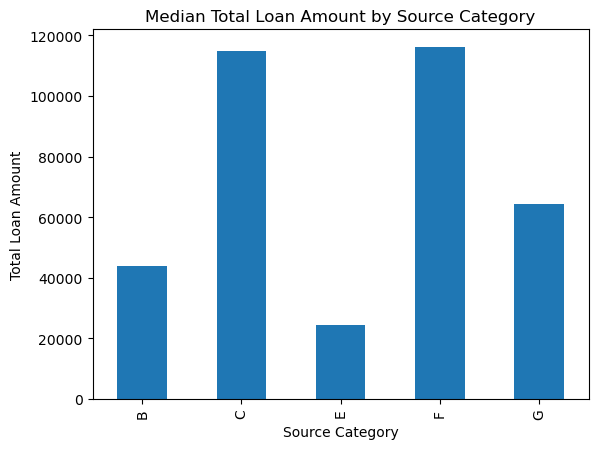

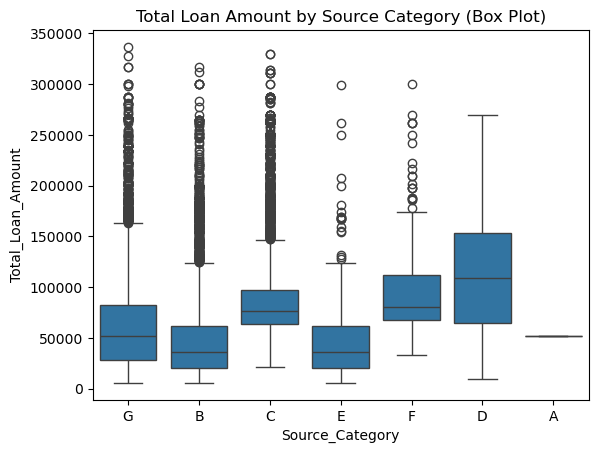

In [15]:

approved_df = df[df["Approved"] == 1]
total_loans = approved_df.groupby("Source_Category")["Total_Loan_Amount"].median()

total_loans.plot(kind="bar")
plt.title("Median Total Loan Amount by Source Category")
plt.ylabel("Total Loan Amount")
plt.xlabel("Source Category")
plt.show()

sns.boxplot(x='Source_Category', y='Total_Loan_Amount', data=df)
plt.title('Total Loan Amount by Source Category (Box Plot)')
plt.show()

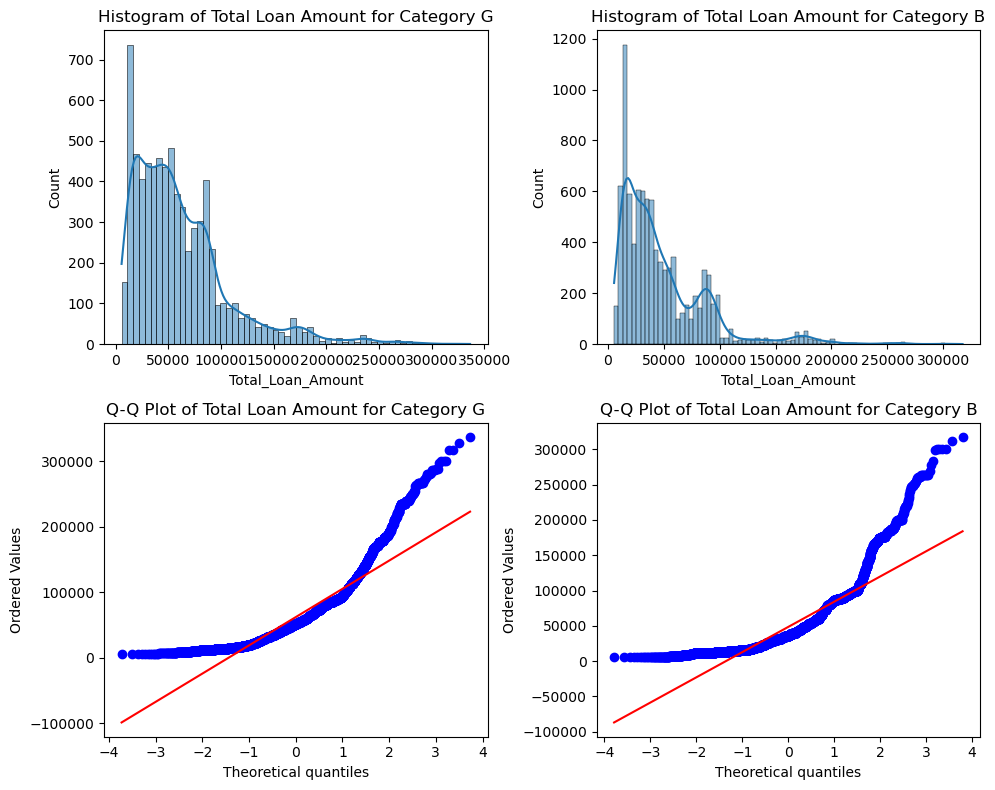

In [16]:
cat_G = df[df["Source_Category"].isin(["G"])]
cat_B = df[df["Source_Category"].isin(["B"])]

cat_G = cat_G.dropna(subset=["Total_Loan_Amount"])
cat_B = cat_B.dropna(subset=["Total_Loan_Amount"])

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

#Histograms of Total Loan Amount
sns.histplot(cat_G["Total_Loan_Amount"], kde=True, ax=axes[0,0])
axes[0,0].set_title("Histogram of Total Loan Amount for Category G")
sns.histplot(cat_B["Total_Loan_Amount"], kde=True, ax=axes[0,1])
axes[0,1].set_title("Histogram of Total Loan Amount for Category B")

#Q-Q Plots of Total loan amount
stats.probplot(cat_G["Total_Loan_Amount"], dist="norm", plot=axes[1,0])
axes[1,0].set_title("Q-Q Plot of Total Loan Amount for Category G")
stats.probplot(cat_B["Total_Loan_Amount"], dist="norm", plot=axes[1,1])
axes[1,1].set_title("Q-Q Plot of Total Loan Amount for Category B")

plt.tight_layout()
plt.show()


From the above plots we can see the data is heavily skewed and does not follow a normal distribution. This is especially apparent in the Q-Q plots. Therefore, I will perform the Mann-Whitney U test.

In [17]:
u_stat, p_value = mannwhitneyu(cat_G["Total_Loan_Amount"], cat_B["Total_Loan_Amount"], alternative="two-sided")

print(f"P-value = {p_value}")

if p_value < alpha:
    print("Reject the null hypothesis, there is a significant difference in the Total Loan Amount between the two groups.")
else:
    print("Fail to reject the null hypothesis, there is no significant difference in the Total Loan Amount between the two groups.")

P-value = 1.346446553936553e-106
Reject the null hypothesis, there is a significant difference in the Total Loan Amount between the two groups.


Since the P-value is significantly below the significance level of 0.05, we reject the null hypothesis. Therefore the G category has a significantly greater Total Loan Amount.

# Logistic Regression:

I will now build a predictive model using logistic regression to predict approval of a bank loan application. Before doing so I must encode the categorical columns into binary columns using One Hot Encoding, as previously mentioned.

The null values will also be imputed using the KNN algorithm. The K-nearest neighbours algorithm will impute null values based on the mean of the 5 closest neighbours of the row in question. Before doing so, I must scale the numerical values as the vast differnce in ranges between variables will result in a poor quality Euclidean distance calculation in the KNNImputer method.

##### Encoding, Scaling, Imputation:

In [18]:
numerical_columns = ["Monthly_Income", "Existing_EMI", "Loan_Amount", "Loan_Period", "Interest_Rate", "EMI", "Total_Loan_Amount", "Age", "Lead_Age"]
categorical_columns = ["Gender", "City_Category", "Employer_Category1", "Employer_Category2", "Primary_Bank_Type", "Contacted", "Source_Category"]
df_log = df

#Using OneHotEncoder to convert categorical columns to numerical
encoder = OneHotEncoder(sparse_output=False, handle_unknown='error')
encoded_columns = encoder.fit_transform(df_log[categorical_columns])

#Add encoded columns back to the DataFrame
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_columns))
df_log = pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1)

print(df_log.dtypes)

#KNN Imputing:

#Scaling numerical columns
scaler = StandardScaler()
scaled_columns = scaler.fit_transform(df_log[numerical_columns])

scaled_df = pd.DataFrame(scaled_columns, columns=scaler.get_feature_names_out(numerical_columns))
df_log = pd.concat([df_log.drop(columns=numerical_columns), scaled_df], axis=1)

imputer = KNNImputer(n_neighbors=5)

imputed_data = imputer.fit_transform(df_log)

# Convert the result back to a DataFrame
df_log = pd.DataFrame(imputed_data, columns=df_log.columns)
print("DataFrame After Imputation:")
print(df_log)

Monthly_Income            float64
Existing_EMI              float64
Loan_Amount               float64
Loan_Period               float64
Interest_Rate             float64
EMI                       float64
Approved                    int64
Lead_Age                  float64
Age                       float64
Total_Loan_Amount         float64
Gender_Female             float64
Gender_Male               float64
City_Category_A           float64
City_Category_B           float64
City_Category_C           float64
City_Category_nan         float64
Employer_Category1_A      float64
Employer_Category1_B      float64
Employer_Category1_C      float64
Employer_Category1_nan    float64
Employer_Category2_1.0    float64
Employer_Category2_2.0    float64
Employer_Category2_3.0    float64
Employer_Category2_4.0    float64
Employer_Category2_nan    float64
Primary_Bank_Type_G       float64
Primary_Bank_Type_P       float64
Primary_Bank_Type_nan     float64
Contacted_N               float64
Contacted_Y   

##### VIF Analysis:

Before proceeding to the logistic regression, I will analyze the VIF (Variance Inflation Factor) scores of the predictor variables. VIF scores are used to detect multicollinearity among the independant variables, if any of the VIF scores are too high (above 10 is the standard threshold) we will know that some of the variables have high multicollinearity with other variables. Highly multicollinear variables risk overfitting the model, reducing the model's ability to generalize to new data.

In [19]:
predictor_variables = df_log.drop(columns=['Approved'])

vifs = pd.DataFrame()
vifs['Feature'] = predictor_variables.columns
vifs['VIF'] = [variance_inflation_factor(predictor_variables.values, i) for i in range(predictor_variables.shape[1])]

print("VIFs before regression:")
print(vifs)

VIFs before regression:
                   Feature           VIF
0            Gender_Female  5.597318e+03
1              Gender_Male  1.239562e+05
2          City_Category_A  4.289051e+04
3          City_Category_B  3.102692e+04
4          City_Category_C  8.636364e+04
5        City_Category_nan  1.300771e+10
6     Employer_Category1_A  3.164695e+04
7     Employer_Category1_B  2.606334e+04
8     Employer_Category1_C  1.376348e+05
9   Employer_Category1_nan  7.217196e+06
10  Employer_Category2_1.0  1.696727e+05
11  Employer_Category2_2.0  9.477563e+07
12  Employer_Category2_3.0  1.190566e+09
13  Employer_Category2_4.0  2.004711e+03
14  Employer_Category2_nan  5.719249e+06
15     Primary_Bank_Type_G  1.082611e+05
16     Primary_Bank_Type_P  2.390920e+05
17   Primary_Bank_Type_nan  1.323379e+06
18             Contacted_N  3.671566e+04
19             Contacted_Y  2.383195e+04
20       Source_Category_A  2.912124e+12
21       Source_Category_B  1.248028e+04
22       Source_Category_C  5.316

As we can see, many of VIF scores are extremely high, indicating that many of the variables have multicollinearity issues. I will create a while loop that will iteratively remove the column with the highest VIF value and recalculate the VIFs until there are no columns left with VIF scores over 10.

In [20]:
while(vifs['VIF'].max() > 10):
    max_VIF = vifs['VIF'].max()
    dropped_column = vifs.loc[vifs['VIF'] == max_VIF, 'Feature'].iloc[0]

    print(f"Dropping {dropped_column}, VIF: {max_VIF}")
    df_log = df_log.drop(columns=[dropped_column])
    predictor_variables = predictor_variables.drop(columns=[dropped_column])

    vifs = pd.DataFrame()
    vifs['Feature'] = predictor_variables.columns
    vifs['VIF'] = [variance_inflation_factor(predictor_variables.values, i) for i in range(predictor_variables.shape[1])]

Dropping Source_Category_A, VIF: 2912123910359.196
Dropping City_Category_nan, VIF: 65332525221.70637
Dropping Employer_Category2_2.0, VIF: 516280162.75854945
Dropping Primary_Bank_Type_nan, VIF: 654160586.0618285
Dropping Employer_Category1_B, VIF: 412139222.2230963


c:\Users\dimdi\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping Gender_Female, VIF: inf
Dropping Contacted_Y, VIF: 15197.369998117312
Dropping City_Category_A, VIF: 69.47832812300553
Dropping Employer_Category2_4.0, VIF: 31.67279008450572
Dropping Total_Loan_Amount, VIF: 18.51951991167427
Dropping Employer_Category1_nan, VIF: 16.142612890802386
Dropping Source_Category_B, VIF: 12.9248116137109


In [21]:
print("VIFs before regression:")
print(vifs)

VIFs before regression:
                   Feature       VIF
0              Gender_Male  5.350031
1          City_Category_B  1.187167
2          City_Category_C  1.359705
3     Employer_Category1_A  2.772578
4     Employer_Category1_C  1.775623
5   Employer_Category2_1.0  1.135784
6   Employer_Category2_3.0  1.047284
7   Employer_Category2_nan  1.574947
8      Primary_Bank_Type_G  3.166814
9      Primary_Bank_Type_P  4.872251
10             Contacted_N  3.679494
11       Source_Category_C  1.803486
12       Source_Category_D  1.063761
13       Source_Category_E  1.035206
14       Source_Category_F  1.032498
15       Source_Category_G  2.228823
16          Monthly_Income  2.259405
17            Existing_EMI  1.257358
18             Loan_Amount  9.436102
19             Loan_Period  1.871734
20           Interest_Rate  1.733664
21                     EMI  8.131278
22                     Age  1.131600
23                Lead_Age  1.055468


Now that the multicollinearity issue is dealt with, the data is ready for logistic regression. I will split the dataframe into separate testing and training data sets.

In [22]:
X = predictor_variables
y = df_log["Approved"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

Now I can fit the logistic regression to the training data and evaluate it using the testing data.

c:\Users\dimdi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dimdi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dimdi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      6870
         1.0       0.00      0.00      0.00       102

    accuracy                           0.99      6972
   macro avg       0.49      0.50      0.50      6972
weighted avg       0.97      0.99      0.98      6972

Accuracy: 0.9853700516351118
Mean ROC-AUC: 0.8109390287077209
Standard Deviation of ROC-AUC: 0.014821339432588749


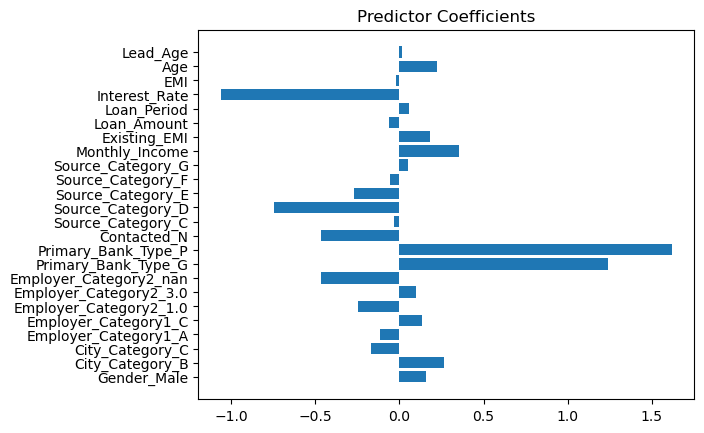

In [23]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

roc_auc_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print(f"Mean ROC-AUC: {roc_auc_scores.mean()}")
print(f"Standard Deviation of ROC-AUC: {roc_auc_scores.std()}")

coef = model.coef_[0]
predictors = X.columns
plt.barh(predictors, coef)
plt.title('Predictor Coefficients')
plt.show()

We can see that the predictive model worked well, with approximately a 99% success rate.

The mean ROC-AUC is 0.81, meaning that the model has good predictive power. A ROC-AUC score of 0.5 would indicate that the model simply makes random guesses, a ROC-AUC score of 1.0 indicates perfect predictive power. Therefore a ROC-AUC score of 0.81 indicates that it can effectively distinguish the outcome.

We can also see that the most important predictors (highest absolute magnitude) are the two primary bank types and the interest rate. The strong positive coefficient of the primary bank types would suggest that customers from those bank types are much more likely to get approved. The high negative coefficient for interest rate would suggest that higher interest rate loans are less likely to be approved. 

Monthly income was the third most important variable with a positive coefficient in predicting approval, meaning that higher montly incomes are more likely to get their loan approved, as would be expected.